In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os

#tensorflow keras imports
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [4]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [9]:
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    mu_t2 = 0.
    sd_m = 0.
    sd_t = 0.
    sd_t2 = 0.
    
    mj1_list = []
    mj2_list = []

    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:

                print("on ...",m1,m2,qq)

                ltau1_m_m = []
                ltau2_m_m = []
                ltau3_m_m = []
                stau1_m_m = []
                stau2_m_m = []
                stau3_m_m = []
                if (m1>0 and m2>0):
                    myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    if (qq=='qqq'):
                        myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qqq/LHCO_RnD_qqq2_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                    jets_m_m = []
                    for line in myfile:
                        jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                        pass
                    ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                    sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                    lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                    smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.
                    
                    #check ordering of the leading and subleading jets
                    #if leading jet mm > subleading, continue
                    #if leading jet mm < subleading, swap
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]

                    ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    ltau3_m_m = np.array([float(ljet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                    stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])
                    stau3_m_m = np.array([float(sjet_m_m[i][7]) for i in range(len(ljet_m_m))])

                    mjj = computemjj_txt(jets_m_m)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]
                    pass
                elif m1==0 and m2==0:
                    df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                    lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                    smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                    
                    #check jet ordering
                    for i in range(int(len(lmass_m_m))):
                        if lmass_m_m[i] > smass_m_m[i]:
                            continue
                        elif lmass_m_m[i] < smass_m_m[i]:
                            lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                    ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                    ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                    ltau3_m_m = np.array(df_QCD[["tau3j1"]]).flatten()
                    stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                    stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                    stau3_m_m = np.array(df_QCD[["tau3j2"]]).flatten()
                    mjj = computemjj_pd(df_QCD)/1000.
                    mjjs[m1,m2] = mjj
                    passcut = (mjj > 3.3) * (mjj < 3.7)
                    lmass_m_m = lmass_m_m[passcut]
                    smass_m_m = smass_m_m[passcut]
                    ltau1_m_m = ltau1_m_m[passcut]
                    ltau2_m_m = ltau2_m_m[passcut]
                    ltau3_m_m = ltau3_m_m[passcut]
                    stau1_m_m = stau1_m_m[passcut]
                    stau2_m_m = stau2_m_m[passcut]
                    stau3_m_m = stau3_m_m[passcut]

                    mu_m = np.mean(lmass_m_m)
                    mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                    mu_t2 = np.mean(ltau3_m_m/(ltau2_m_m+0.0001))
                    sd_m = np.std(lmass_m_m)
                    sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                    sd_t2 = np.std(ltau3_m_m/(ltau2_m_m+0.0001))
                    pass
                else:
                    continue

                ms = np.stack([lmass_m_m,smass_m_m],axis=1)
                ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
                ts2 = np.stack([ltau3_m_m/(ltau2_m_m+0.0001),stau3_m_m/(stau2_m_m+0.001)],axis=1)
                order1 = [np.argmax(ms[i]) for i in range(len(ms))]
                order2 = [np.argmin(ms[i]) for i in range(len(ms))]
                mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
                mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
                
                mj1_list.append(mJ1)
                mj2_list.append(mJ2)
                x[m1,m2,qq] = np.stack([(mJ2 - mu_m)/sd_m,
                                        ((mJ1 - mJ2) - mu_m)/sd_m,
                                        ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                        ([ts2[i][order2[i]] for i in range(len(ts2))] - mu_t2)/sd_t2,
                                        ([ts2[i][order1[i]] for i in range(len(ts2))] - mu_t2)/sd_t2],axis=1)
                lmass_vec[m1,m2]=lmass_m_m
                pass
            pass
        pass
    
    x_array = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array+=[x[m1,m2,qq]]
                
    x_array_qqq = []
    for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qqq in ['qq','qqq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                x_array_qqq+=[x[m1,m2,qqq]]
    # np.save("x_array_qq",x_array)
    # np.save("x_array_qqq",x_array_qqq)

In [4]:
# count = 0
# for i in range(len(mj1_list)):
#     if mj1_list[3][i] > mj2_list[4][i]:
#         #print("greater")
#         count+=1
# print(f"{count} instances of mj1 > mj2")

In [4]:
x = {}
x_array_read = np.load("x_array_qq.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qq] = x_array_read[mycounter]
            
x_array_read = np.load("x_array_qqq.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qqq in ['qq','qqq']:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            mycounter+=1
            x[m1,m2,qqq] = x_array_read[mycounter]

In [5]:
np.shape(x[0,0, qq])

(121352, 6)

In [6]:
np.shape(x[0,0, qqq])

(121352, 6)

In [5]:
x_vals_qq = np.load("x_vals_qq.npy")
y_vals_qq = np.load("y_vals_qq.npy")

In [4]:
x_vals_qqq = []
y_vals_qqq = []
for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for qq in ['qqq']:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0,qq],m1*np.reshape(np.ones(len(x[0,0,qq])),[len(x[0,0,qq]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq])),[len(x[0,0,qq]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2,qq],m1*np.reshape(np.ones(len(x[m1,m2,qq])),[len(x[m1,m2,qq]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq])),[len(x[m1,m2,qq]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_qqq = np.concatenate([x_aug_0,x_aug_m])
                y_vals_qqq = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_qqq = np.concatenate([x_vals_qqq,x_aug_0,x_aug_m])
                y_vals_qqq= np.concatenate([y_vals_qqq,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])

# np.save("x_data_qqq",x_vals_qqq)
# np.save("y_data_qqq",y_vals_qqq)

In [10]:
np.shape(y_vals_qq)

(27249420,)

In [89]:
x_vals_qqq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/x_vals_qqq.npy")
y_vals_qqq = np.load("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/y_vals_qqq.npy")
x_vals_qqq

array([[-1.08511704, -0.13951411,  0.29623825, ...,  0.66468713,
         0.5       ,  0.5       ],
       [-0.99621376, -0.3906208 ,  1.87209617, ..., -0.0247789 ,
         0.5       ,  0.5       ],
       [-1.10503705,  1.30397829,  1.37879233, ..., -1.97102352,
         0.5       ,  0.5       ],
       ...,
       [ 2.2109325 , -1.29862218, -0.64678843, ..., -1.03922943,
         6.        ,  6.        ],
       [-0.07629947,  1.26618006, -1.30987491, ..., -2.06515878,
         6.        ,  6.        ],
       [ 2.29900064, -1.22764083, -1.36945619, ..., -3.42621644,
         6.        ,  6.        ]])

In [14]:
x_data_qqq = np.load("x_data_qqq.npy")
y_data_qqq = np.load("y_data_qqq.npy")

In [88]:
x_data_qqq

array([[-1.51676489, -0.61369051, -1.38973318, ...,  1.32714999,
         0.5       ,  0.5       ],
       [-1.36743797, -1.69854625,  0.49229683, ...,  0.39275729,
         0.5       ,  0.5       ],
       [-0.91169568, -1.71429933,  1.16178254, ...,  0.62902032,
         0.5       ,  0.5       ],
       ...,
       [ 1.63104462, -1.72066763, -0.6480904 , ..., -1.03439472,
         6.        ,  6.        ],
       [-0.55331895,  0.72878247, -1.31312993, ..., -2.06030751,
         6.        ,  6.        ],
       [ 1.71515189, -1.65287867, -1.37288671, ..., -3.42134321,
         6.        ,  6.        ]])

In [10]:
X_train_qq, X_val_qq, Y_train_qq, Y_val_qq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5)

In [84]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qq = Sequential()
model_qq.add(Dense(256, input_dim=8, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(256, activation='swish'))
model_qq.add(BatchNormalization())
model_qq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qq = model_qq.fit(X_train_qq, Y_train_qq, epochs=5000,validation_data=(X_val_qq, Y_val_qq),batch_size=5*1024,callbacks=[es])

plt.plot(myhistory_qq.history['val_loss'][1:])
plt.plot(myhistory_qq.history['loss'][1:])

Epoch 1/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.2587 - accuracy: 0.8976 - val_loss: 0.2046 - val_accuracy: 0.9232
Epoch 2/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1937 - accuracy: 0.9267 - val_loss: 0.1833 - val_accuracy: 0.9298
Epoch 3/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1778 - accuracy: 0.9316 - val_loss: 0.1716 - val_accuracy: 0.9336
Epoch 4/5000
2662/2662 [==============================] - 27s 10ms/step - loss: 0.1687 - accuracy: 0.9346 - val_loss: 0.1650 - val_accuracy: 0.9359
Epoch 5/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1632 - accuracy: 0.9367 - val_loss: 0.1604 - val_accuracy: 0.9377
Epoch 6/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1593 - accuracy: 0.9383 - val_loss: 0.1571 - val_accuracy: 0.9391
Epoch 7/5000
2662/2662 [==============================] - 26s 10ms/step - loss: 0.1563 - accuracy: 0.9395 - val_

KeyboardInterrupt: 

In [85]:
#model_qq.save('model_qq_v2')

INFO:tensorflow:Assets written to: model_qq_v2/assets


In [7]:
model_qq = tf.keras.models.load_model("model_qq_v2")

2024-01-01 21:23:05.487174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 21:23:06.755457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 33909 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [41]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

qq = 'qq'

xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []

#for sigfrac in np.logspace(-3,-1,20):
print(sigfrac)
sigfrac = 0.07

w1 = 3
w2 = 3.5
# if (sigfrac > 0.5):
#     continue

for l in model_qq.layers:
    l.trainable=False

inputs_hold = tf.keras.Input(shape=(1,))
simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
model3 = Model(inputs = inputs_hold, outputs = simple_model)

inputs_hold2 = tf.keras.Input(shape=(1,))
simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

inputs_hold3 = tf.keras.Input(shape=(1,))
simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

inputs = tf.keras.Input(shape=(6,))
inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_qq(inputs2)
LLR = hidden_layer_1 / (1.-hidden_layer_1)
LLR_xs = 1.+sigfrac*LLR - sigfrac
#LLR_xs = 1 + model33(tf.ones_like(inputs)[:,0])*LLR
ws = LLR_xs / (1.+LLR_xs+0.0001)
model_all2 = Model(inputs = inputs, outputs = ws)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

m1 = 3.5
m2 = 5.5

test_background = int(1/2 *len(x[0,0, qq]))
train_background = int(1/4 * len(x[0,0,qq]))
train_data = int(1/4 * len(x[0,0,qq]))
train_reference = int(1/4 * len(x[0,0,qq]))
#signal
test_signal_length = int(1/2*len(x[m1,m2,qq]))
sig_frac = sigfrac

N = int(1/4 * len(x[0,0,qq]))
signal = x[m1,m2,qq][test_signal_length:test_signal_length+int(sig_frac*N)]

x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

#print(N,len(x[0,0,qq])-N,len(x[m1,m2,qq][0:int(sig_frac*N)]),len(x[m1,m2,qq][0:int(sig_frac*N)])/N)

X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

with tf.device('/GPU:0'):
    myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
xx+=[sigfrac]
yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
#ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    # scores = model_all2.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
    # y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    # fpr, tpr, _ = metrics.roc_curve(y, scores)    

#     model_cwola = Sequential()
#     model_cwola.add(Dense(128, input_dim=6, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(128, activation='relu'))
#     model_cwola.add(Dense(1, activation='sigmoid'))
#     model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024)

#     scores2 = model_cwola.predict(np.concatenate([x[0,0,qq][0:test_background],x[m1,m2,qq][0:test_signal_length]]),batch_size=1024)
#     y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
#     fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
#     plt.plot(tpr,tpr/np.sqrt(fpr+0.0001))
#     plt.plot(tpr2,tpr2/np.sqrt(fpr2+0.0001))

#     msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
#     msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

0.07
3.5 5.5 3.4668512 5.506187


In [42]:
plt.plot(xx,ww,label="Weakly")
plt.plot(xx,xx,ls=":",color="black")

plt.title("Fitted S/B")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("sigfrac")
plt.ylabel("Fitted S/B")

(0.0, 700.0)

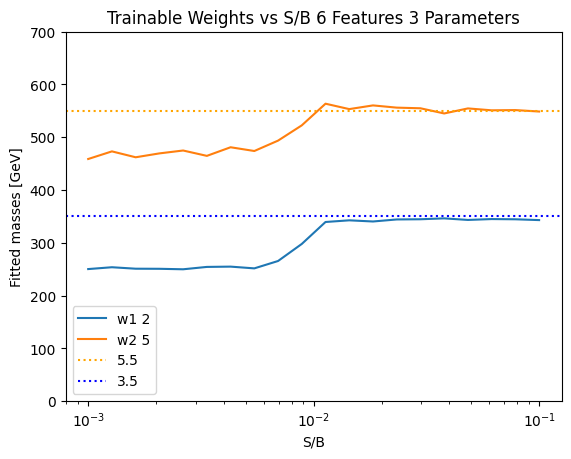

In [32]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs S/B 6 Features 3 Parameters")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

Text(0, 0.5, 'Max SIC')

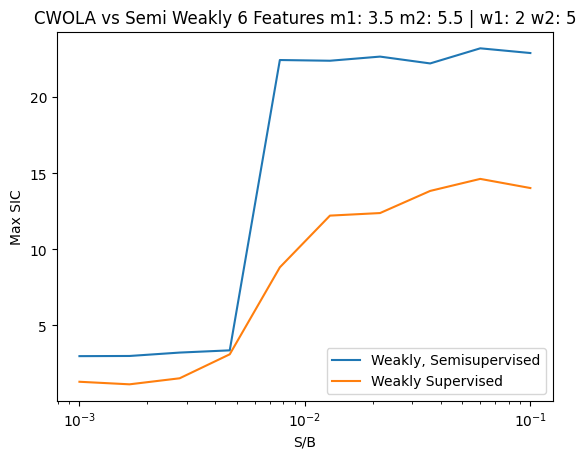

In [88]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly 6 Features m1: {m1} m2: {m2} | w1: {w1} w2: {w2}")
plt.legend()
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Max SIC")

In [8]:
#fixed signal mass pair, different initializations of weights
from models import createSimpleModel
qq = "qq"

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
initial_weights_list_runs = []

num_runs = 5

for _ in range(num_runs):
    
    sig_list = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    
    msic1 = []
    msic2 = []
    msic3 = []

    epsilon = 1e-6

    # w1 = round(random.uniform(0.5, 6.0),3)
    # w2 = round(random.uniform(0.5, 6.0),3)

    w1 = 2
    w2 = 5
    
    initial_weights_list_runs.append((w1, w2))

    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_qq.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        
        #physics prior
        hidden_layer_1 = model_qq(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        
        #LLR_xs = 1.+sigfrac*LLR - sigfrac
        LLR_xs = 1.+ model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3.5
        m2 = 5.5

        test_background = int(1/2 * len(x[0,0, qq]))
        train_reference = int(1/4 *len(x[0,0, qq]))
        train_data = int(1/4 * len(x[0,0, qq]))
        test_signal = int(1/2*len(x[m1,m2, qq]))
        sig_frac = sigfrac
        
        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, qq])))
        signal = x[m1, m2, qq][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #N = train_reference
        x_data_ = np.concatenate([x[0,0, qq][test_background:],signal])
        y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=100,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0, qq][0:test_background],x[m1,m2, qq][0:test_signal]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0, qq][0:test_background],x[m1,m2, qq][0:test_signal]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
        #fully supervised
        model3_full = createSimpleModel(w1)
        model32_full = createSimpleModel(w2)

        inputs = tf.keras.Input(shape=(6,))
        inputs2_full = tf.keras.layers.concatenate([inputs,model3_full(tf.ones_like(inputs)[:,0]),model32_full(tf.ones_like(inputs)[:,0])])
        hidden_layer_1_full = model_qq(inputs2_full)
        model_all2_full = Model(inputs = inputs, outputs = hidden_layer_1_full)
        model_all2_full.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        x_data_full = np.concatenate([x[0,0, qq],x[m1,m2, qq]])
        y_data_full = np.concatenate([np.zeros(len(x[0,0, qq])),np.ones(len(x[m1,m2, qq]))])
        X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5)
        myhistory_hack_ = model_all2_full.fit(X_train_full[:,0:6], Y_train_full, epochs=20,validation_data=(X_val_full[:,0:6], Y_val_full),batch_size=1024, verbose = 0)

        scores_full = model_all2_full.predict(np.concatenate([x[0,0, qq][0:test_background],x[m1,m2, qq][0:random_test_signal_length]]),batch_size=1024)
        y_full = np.concatenate([np.zeros(test_background),np.ones(random_test_signal_length)])
        fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)

        msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
        msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
        msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])

    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)

2 5 0.001
3.5 5.5 2.4711888 4.6343465
73/73 [==============================] - 0s 1ms/step
2 5 0.0012742749857031334
3.5 5.5 2.4193661 4.740995
61/61 [==============================] - 0s 1ms/step
2 5 0.001623776739188721
3.5 5.5 2.448431 4.69523
85/85 [==============================] - 0s 1ms/step
2 5 0.00206913808111479
3.5 5.5 2.4019735 4.721953
67/67 [==============================] - 0s 967us/step
2 5 0.0026366508987303583
3.5 5.5 2.4579456 4.697253
87/87 [==============================] - 0s 1ms/step
2 5 0.003359818286283781
3.5 5.5 2.4496508 4.676805
79/79 [==============================] - 0s 977us/step
2 5 0.004281332398719396
3.5 5.5 2.4529061 4.8072276
75/75 [==============================] - 0s 1ms/step
2 5 0.00545559478116852
3.5 5.5 2.4640336 4.8094687
81/81 [==============================] - 0s 1ms/step
2 5 0.0069519279617756054
3.5 5.5 3.3565915 5.635984
65/65 [==============================] - 0s 952us/step
2 5 0.008858667904100823
3.5 5.5 3.4468362 5.6705465
82/82 [==

In [7]:
len(x[0,0, qq][0:test_background])

60676

In [23]:
len(x[m1,m2, qq][0:random_test_signal_length])

17549

In [14]:
max_sics = {}
max_sics[("SWS", 6, 3, m1, m2, w1, w2)] = msic1_runs
max_sics[("WS", 6, 3, m1, m2, w1, w2)] = msic2_runs
max_sics[("FS", 6, 3, m1, m2, w1, w2)] = msic3_runs

import pickle
with open('max_sics_3.55.5_6Feature3param.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

Text(0, 0.5, 'Avg Max SIC')

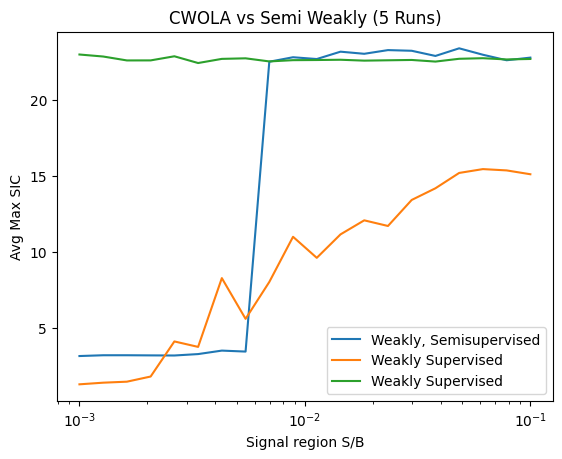

In [10]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Weakly Supervised")
plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [16]:
np.save("6paramweights3.55.5Perturb.npy", weight_list3_runs)

Text(0, 0.5, 'Avg Max SIC')

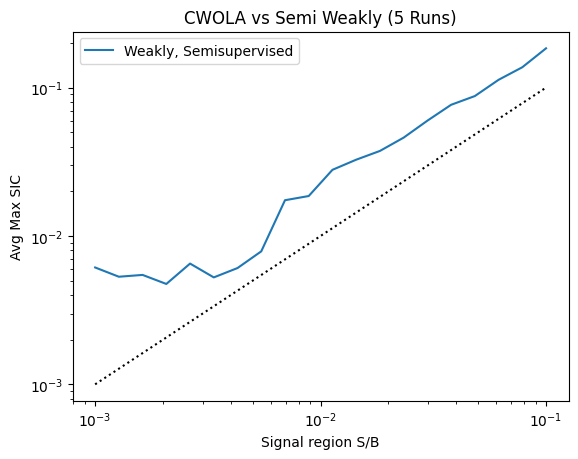

In [12]:
avgww = np.median(weight_list3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(sig_list,avgww,label="Weakly, Semisupervised")
plt.plot(sig_list,sig_list,ls=":",color="black")

plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

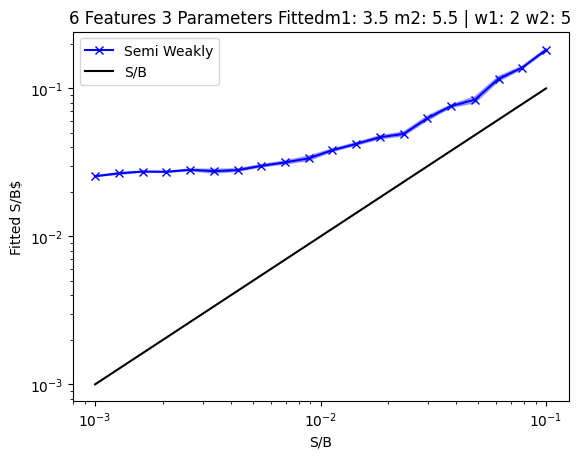

In [45]:
signal_fraction_values = np.logspace(-3, -1, 20)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='blue')
plt.plot(xx, xx, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')

plt.ylabel(r'Fitted S/B$')
plt.title(f'6 Features 3 Parameters Fittedm1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [7]:
import time

#3pronged decay
qq = "qq"
start_time = time.time()

def create_loss_landscape_6Features(model, m1, m2):
    
    Nfeatures = 6
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}morefps33.5.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-4
    sig_space = np.logspace(-3, -1, 40)
    
    #if we want a specific sigfrac
    #sig_space = [0.1]
    
    start = 0.5
    end = 6
    step = 0.125

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        count = 0
        for w1 in weight_list:
            for w2 in weight_list:
                if count % 1000 == 0:
                    print(f"reached {w1} {w2}")
                count+=1
                #print(w1, w2)
                sigfrac = sig

                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq]))
                train_background = int(1/4 * len(x[0,0,qq]))
                train_data = int(1/4 * len(x[0,0,qq]))
                train_reference = int(1/4 * len(x[0,0,qq]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq])))
                signal = x[m1, m2,qq][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0,qq][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Total elapsed time: 0.0 seconds


In [ ]:
create_loss_landscape_6Features(model_qqq, 3.5, 5.5)

Signal Fraction:  0.001
reached 0.5 0.5
Time taken: 1695.834 seconds
Signal Fraction:  0.0011253355826007646
reached 0.5 0.5
Time taken: 3328.398 seconds
Signal Fraction:  0.0012663801734674035
reached 0.5 0.5
Time taken: 4967.724 seconds
Signal Fraction:  0.0014251026703029977
reached 0.5 0.5
Time taken: 6623.419 seconds
Signal Fraction:  0.001603718743751331
reached 0.5 0.5
Time taken: 8263.684 seconds
Signal Fraction:  0.0018047217668271701
reached 0.5 0.5
Time taken: 9899.988 seconds
Signal Fraction:  0.002030917620904735
reached 0.5 0.5
Time taken: 11693.188 seconds
Signal Fraction:  0.0022854638641349907
reached 0.5 0.5
Time taken: 23606.089 seconds
Signal Fraction:  0.0052233450742668434
reached 0.5 0.5
Time taken: 25199.263 seconds
Signal Fraction:  0.0058780160722749115
reached 0.5 0.5
Time taken: 26474.212 seconds
Signal Fraction:  0.006614740641230145
reached 0.5 0.5
Time taken: 27753.02 seconds
Signal Fraction:  0.0074438030132516885
reached 0.5 0.5
Time taken: 28966.104 se

In [8]:
create_loss_landscape_6Features(model_qq, 3.5, 5.5)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.001
reached 0.5 0.5


2023-12-31 09:00:26.993066: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


KeyboardInterrupt: 

In [ ]:
create_loss_landscape_6Features(model_qq, 2, 5)

Signal Fraction:  0.001
Time taken: 29769.496 seconds
Signal Fraction:  0.0012742749857031334
Time taken: 30525.919 seconds
Signal Fraction:  0.001623776739188721
Time taken: 31285.205 seconds
Signal Fraction:  0.00206913808111479
Time taken: 32070.743 seconds
Signal Fraction:  0.0026366508987303583
Time taken: 32950.64 seconds
Signal Fraction:  0.003359818286283781
Time taken: 33757.107 seconds
Signal Fraction:  0.004281332398719396
Time taken: 34478.88 seconds
Signal Fraction:  0.00545559478116852
Time taken: 35191.248 seconds
Signal Fraction:  0.0069519279617756054
Time taken: 35904.252 seconds
Signal Fraction:  0.008858667904100823
Time taken: 36614.143 seconds
Signal Fraction:  0.011288378916846888
Time taken: 37497.193 seconds
Signal Fraction:  0.01438449888287663


In [23]:
z_allm1m2_HD = np.load("z_allm1m2_6FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_HD.keys()

dict_keys([(0.0379269019073225, 3, 4.5), (0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5)])

In [31]:
from IPython.display import display, clear_output
from PIL import Image, ImageSequence
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        # Append the image to the frames list
        frames.append(Image.open(image_path))

    # Create the final GIF that combines all frames
    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)

In [16]:
X_train_qqq, X_val_qqq, Y_train_qqq, Y_val_qqq = train_test_split(x_data_qqq, y_data_qqq, test_size=0.5)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [8]:
model_qqq = tf.keras.models.load_model("model_qqq")

In [146]:
sigmoid = lambda x: 1. / (1. + np.exp(-x))

In [156]:
from models import createSimpleModel
decay = 'qqq'

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
weight_list4_runs = []
initial_weights_list_runs = []

num_runs = 5

for _ in range(num_runs):

    sig_list = []
    
    msic1 = []
    msic2 = []
    msic3 = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    weight_list4 = []

    sigspace = np.logspace(-3, -1, 20)

    # w1 = round(random.uniform(0.5, 6.0),3)
    # w2 = round(random.uniform(0.5, 6.0),3)

    #print(w1, w2)
    for sigfrac in sigspace:

        #freeze both two pronged and three pronged prior models
        for l in model_qq.layers:
            l.trainable=False

        for l in model_qqq.layers:
            l.trainable=False

        #sigfrac = 0.1
        print(sigfrac, w1, w2)

        w1, w2 = 3.241, 3.649 
        
        initial_weights_list_runs.append((w1, w2))

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs_hold4 = tf.keras.Input(shape=(1,))
        simple_model4 = Dense(1,use_bias = False,activation='sigmoid',kernel_initializer=tf.keras.initializers.Constant(1.))(inputs_hold4)
        model34 = Model(inputs = inputs_hold4, outputs = simple_model4)

        inputs = tf.keras.Input(shape=(6,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_qq(inputs2)
        hidden_layer_13 = model_qqq(inputs2)
        LLR2 = hidden_layer_1 / (1.-hidden_layer_1+0.0001)
        LLR3 = hidden_layer_13 / (1.-hidden_layer_13+0.0001)
        #LLR_xs = 1.+ sigfrac*LLR3 - sigfrac
        LLR_xs_fixed = 1 + model33(tf.ones_like(inputs)[:,0])*model34(tf.ones_like(inputs)[:,0]) * LLR3 + (1-model34(tf.ones_like(inputs)[:,0]))*LLR2*model33(tf.ones_like(inputs)[:,0])
        ws = LLR_xs_fixed / (1.+LLR_xs_fixed+0.0001)
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 3

        test_background = int(1/2 * len(x[0,0, decay]))
        train_reference = int(1/4 *len(x[0,0, decay]))
        train_data = int(1/4 * len(x[0,0, decay]))
        test_signal = int(1/2*len(x[m1,m2, decay]))
        sig_frac = sigfrac

        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0, decay])))
        signal = x[m1, m2, decay][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        x_data_ = np.concatenate([x[0,0,decay][test_background:],signal])
        y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:6], Y_train_, epochs=20,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])

        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        weight_list4+=[sigmoid(model_all2.trainable_weights[3].numpy()[0][0])]

        scores = model_all2.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024, verbose = 0)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=6, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:6], Y_train_, epochs=10,validation_data=(X_val_[:,0:6], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:test_signal]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
        #fully supervised
        model3_full = createSimpleModel(w1)
        model32_full = createSimpleModel(w2)

        inputs = tf.keras.Input(shape=(6,))
        inputs2_full = tf.keras.layers.concatenate([inputs,model3_full(tf.ones_like(inputs)[:,0]),model32_full(tf.ones_like(inputs)[:,0])])
        hidden_layer_1_full = model_qqq(inputs2_full)
        model_all2_full = Model(inputs = inputs, outputs = hidden_layer_1_full)
        model_all2_full.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        x_data_full = np.concatenate([x[0,0, decay],x[m1,m2, decay]])
        y_data_full = np.concatenate([np.zeros(len(x[0,0, decay])),np.ones(len(x[m1,m2, decay]))])
        X_train_full, X_val_full, Y_train_full, Y_val_full = train_test_split(x_data_full, y_data_full, test_size=0.5)
        myhistory_hack_ = model_all2_full.fit(X_train_full[:,0:6], Y_train_full, epochs=20,validation_data=(X_val_full[:,0:6], Y_val_full),batch_size=1024, verbose = 0)

        scores_full = model_all2_full.predict(np.concatenate([x[0,0, decay][0:test_background],x[m1,m2, decay][0:random_test_signal_length]]),batch_size=1024)
        y_full = np.concatenate([np.zeros(test_background),np.ones(random_test_signal_length)])
        fpr_full, tpr_full, _ = metrics.roc_curve(y_full, scores_full)
        
        msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
        msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
        msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])
        
    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)
    weight_list4_runs.append(weight_list4)

0.001 3.241 3.649
3 3 2.822676 4.329164
97/97 [==============================] - 0s 865us/step
0.0012742749857031334 3.241 3.649
3 3 2.8296752 4.423614
73/73 [==============================] - 0s 869us/step
0.001623776739188721 3.241 3.649
3 3 2.8320074 4.3532333
83/83 [==============================] - 0s 865us/step
0.00206913808111479 3.241 3.649
3 3 2.9378471 4.3290515
62/62 [==============================] - 0s 880us/step
0.0026366508987303583 3.241 3.649
3 3 2.9092696 4.3511953
69/69 [==============================] - 0s 863us/step
0.003359818286283781 3.241 3.649
3 3 2.9433086 4.229423
88/88 [==============================] - 0s 889us/step
0.004281332398719396 3.241 3.649
3 3 2.9529424 4.2480965
77/77 [==============================] - 0s 987us/step
0.00545559478116852 3.241 3.649
3 3 2.8878753 4.2644663
88/88 [==============================] - 0s 933us/step
0.0069519279617756054 3.241 3.649
3 3 2.9315917 4.084256
91/91 [==============================] - 0s 884us/step
0.008858667

In [160]:
np.save("3ProngWeight_List3_Runs33", weight_list3_runs)
np.save("3ProngWeight_List4_Runs33", weight_list4_runs)

Text(0, 0.5, 'Avg Max SIC')

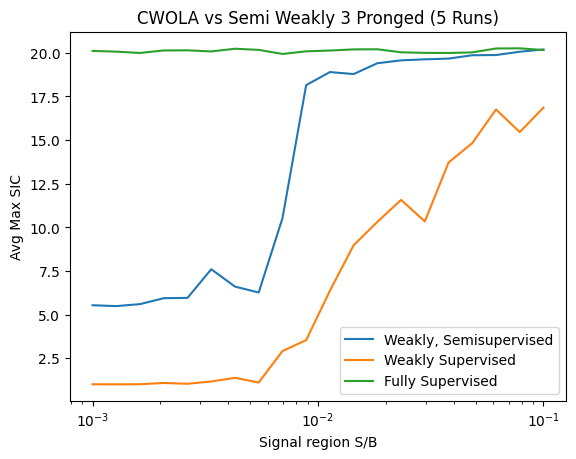

In [136]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly 3 Pronged ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

Text(0, 0.5, 'Avg Max SIC')

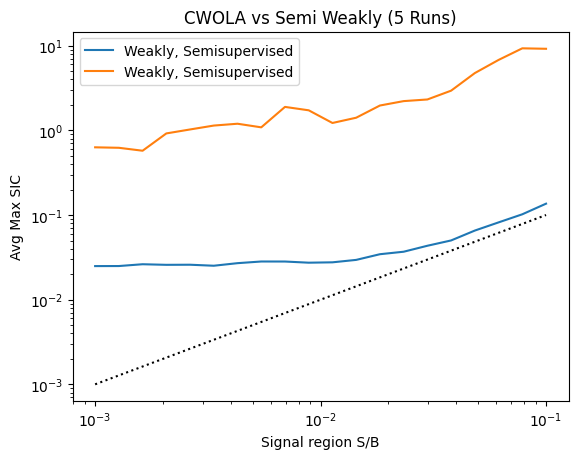

In [137]:
avgww = np.median(weight_list3_runs, axis = 0)
avgww2 = np.median(weight_list4_runs, axis = 0)

plt.plot(sig_list,avgww,label="Weakly, Semisupervised")
plt.plot(sig_list,avgww2,label="Weakly, Semisupervised")
plt.plot(sig_list,sig_list,ls=":",color="black")

plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

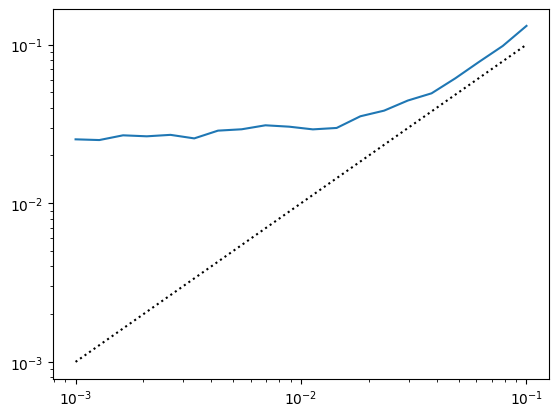

In [148]:
plt.plot(sig_list, weight_list3)
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.yscale("log")
plt.xscale("log")

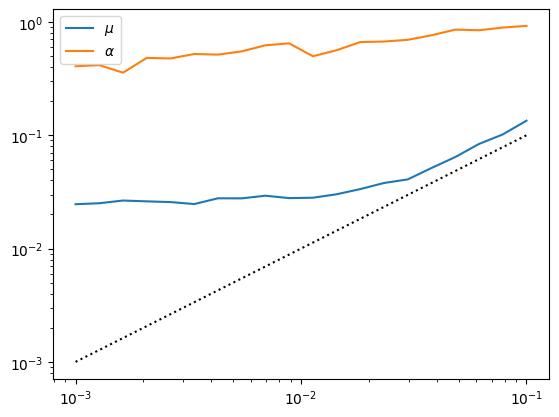

In [158]:
plt.plot(sig_list, weight_list3, label = r"$\mu$")
plt.plot(sig_list, weight_list4, label = r"$\alpha$")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [150]:
weight_list4

[0.3767170527377324,
 0.37994988358650317,
 0.344174566079353,
 0.46949481530708576,
 0.45346395839072395,
 0.48261659109596655,
 0.5261962837101426,
 0.4542124446922181,
 0.563425167173285,
 0.5786436907231542,
 0.3499912299923248,
 0.3445308702831791,
 0.32383741606046135,
 0.30623489653675917,
 0.2773798511172029,
 0.3336994160603919,
 0.28125227989614404,
 0.2684366414162085,
 0.2681577046852719,
 0.28224222164112023]

(0.0, 700.0)

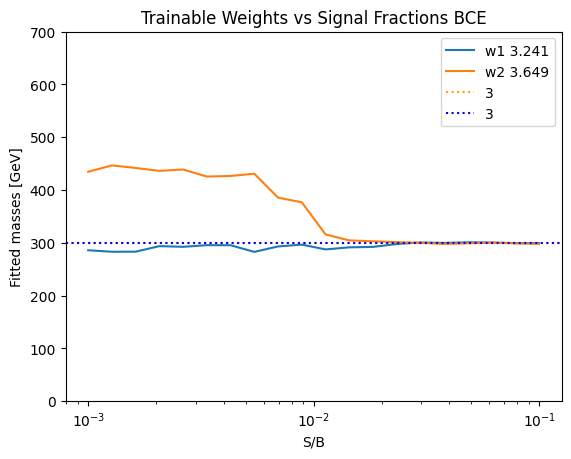

In [93]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

In [95]:
# plt.plot(sig_list,msic,label="Fully Supervised")
# plt.title(f"CWOLA vs Semi Weakly 3 Prong")
# plt.legend()
# plt.xscale("log")
# plt.xlabel("Signal region S/B")
# plt.ylabel("Max SIC")

In [139]:
max_sics = {}
max_sics[("SWS", 6, 4, m1, m2, w1, w2)] = msic1_runs
max_sics[("WS", 6, 4, m1, m2, w1, w2)] = msic2_runs
max_sics[("FS", 6, 4, m1, m2, w1, w2)] = msic3_runs

import pickle
with open('max_sics_3prong33pertb.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [21]:
if (True):
    
    model_qqq = Sequential()
    model_qqq.add(Dense(256, input_dim=8, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(256, activation='swish'))
    model_qqq.add(BatchNormalization())
    model_qqq.add(Dense(1, activation='sigmoid'))
    model_qqq.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=500,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])
    
    plt.plot(myhistory_qqq.history['val_loss'][1:])
    plt.plot(myhistory_qqq.history['loss'][1:])
    
    model_qqq.save('model_qqq')

Epoch 1/500
2692/2692 [==============================] - 11s 4ms/step - loss: 0.1674 - accuracy: 0.9340 - val_loss: 0.1564 - val_accuracy: 0.9386
Epoch 2/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1542 - accuracy: 0.9391 - val_loss: 0.1539 - val_accuracy: 0.9393
Epoch 3/500
2692/2692 [==============================] - 9s 3ms/step - loss: 0.1530 - accuracy: 0.9396 - val_loss: 0.1529 - val_accuracy: 0.9396
Epoch 4/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1523 - accuracy: 0.9398 - val_loss: 0.1525 - val_accuracy: 0.9399
Epoch 5/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1518 - accuracy: 0.9400 - val_loss: 0.1517 - val_accuracy: 0.9400
Epoch 6/500
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1514 - accuracy: 0.9402 - val_loss: 0.1511 - val_accuracy: 0.9404
Epoch 7/500
2692/2692 [==============================] - 9s 4ms/step - loss: 0.1511 - accuracy: 0.9403 - val_loss: 0.1517 - va

KeyboardInterrupt: 

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_qqq = Sequential()
model_qqq.add(Dense(256, input_dim=8, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(256, activation='swish'))
model_qqq.add(BatchNormalization())
model_qqq.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_qqq.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_qqq = model_qqq.fit(X_train_qqq, Y_train_qqq, epochs=5000,validation_data=(X_val_qqq, Y_val_qqq),batch_size=5*1024,callbacks=[es])

Epoch 1/5000
2692/2692 [==============================] - 13s 4ms/step - loss: 0.2904 - accuracy: 0.8848 - val_loss: 0.2361 - val_accuracy: 0.9107
Epoch 2/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2222 - accuracy: 0.9152 - val_loss: 0.2095 - val_accuracy: 0.9189
Epoch 3/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.2026 - accuracy: 0.9209 - val_loss: 0.1963 - val_accuracy: 0.9230
Epoch 4/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1926 - accuracy: 0.9242 - val_loss: 0.1890 - val_accuracy: 0.9256
Epoch 5/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1866 - accuracy: 0.9265 - val_loss: 0.1841 - val_accuracy: 0.9274
Epoch 6/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1824 - accuracy: 0.9281 - val_loss: 0.1803 - val_accuracy: 0.9291
Epoch 7/5000
2692/2692 [==============================] - 10s 4ms/step - loss: 0.1792 - accuracy: 0.9294 - val_loss: 0

KeyboardInterrupt: 

In [56]:
#model_qqq.save('model_qqq')

INFO:tensorflow:Assets written to: model_qqq/assets
